<a href="https://colab.research.google.com/github/viniciusrpb/cic0269_natural_language_processing/blob/main/lectures/cap15_1_seq2seq_machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capítulo 15 - Arquiteturas Encoder-Decoder

## Modelos *Sequence to Sequence* (seq2seq)

## Machine Translation

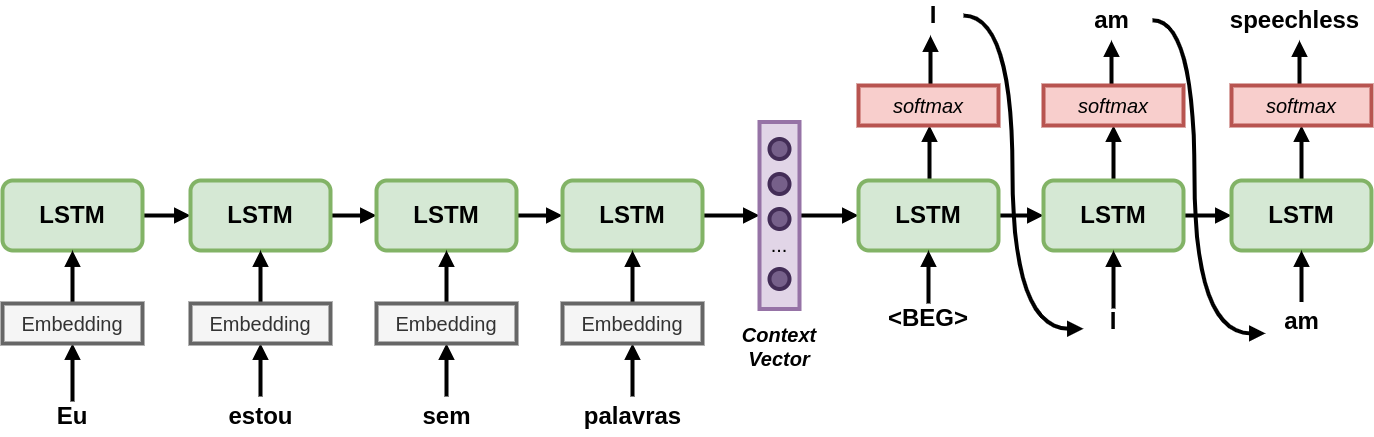

In [ ]:
!pip install tensorflow-datasets

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense,Embedding,Bidirectional,LSTM,Activation,Input,Dropout,BatchNormalization

In [3]:
ds_train = tfds.load('ted_hrlr_translate/pt_to_en', split='train',
                     shuffle_files=True,
                     with_info=True,
                     as_supervised=True)

ds_valid = tfds.load('ted_hrlr_translate/pt_to_en', split='validation',
                     shuffle_files=False,
                     with_info=True,
                     as_supervised=True)

ds_test = tfds.load('ted_hrlr_translate/pt_to_en', split='test',
                    shuffle_files=False,
                    with_info=True,
                    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete1YC8YL/ted_hrlr_translate-train.tf…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete1YC8YL/ted_hrlr_translate-validati…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete1YC8YL/ted_hrlr_translate-test.tfr…

Dataset ted_hrlr_translate downloaded and prepared to ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [4]:
def ds2DataFrame(ds):
    
    dic = {}
    dic['pt'] = []
    dic['en'] = []
    for elem in ds[0]:
        port = elem[0].numpy().decode('utf-8')
        eng = elem[1].numpy().decode('utf-8')
        dic['pt'].append(port)
        dic['en'].append(eng)

    return pd.DataFrame.from_dict(dic)

In [5]:
df_train = ds2DataFrame(ds_train)
df_valid = ds2DataFrame(ds_valid)
df_test = ds2DataFrame(ds_test)

In [6]:
df_train

,pt,en
0,"e quando melhoramos a procura , tiramos a únic...","and when you improve searchability , you actua..."
1,mas e se estes fatores fossem ativos ?,but what if it were active ?
2,mas eles não tinham a curiosidade de me testar .,but they did n't test for curiosity .
3,e esta rebeldia consciente é a razão pela qual...,"and this conscious defiance is why i , as an a..."
4,`` `` '' podem usar tudo sobre a mesa no meu c...,you can use everything on the table on me .
...,...,...
51780,"que a ideia louca é mesmo isso , é louca , e c...","that the crazy idea is just that , it is crazy..."
51781,"agora , em ambos os casos , não mandei nenhum ...","now in both cases , i did n't send them home a..."
51782,"na linha pontilhada a vermelho , mostramos qua...","in the dotted red line , we show what the adop..."
51783,"agora , a lagarta não morreu .","now , the caterpillar did n't die ."


In [7]:
def encoder_model(neurons, input_len):
    encoder_inputs = Input(shape=(None, input_len))
    encoder = LSTM(neurons, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    return encoder_states

In [8]:
def decoder_part(neurons,input_len,encoder_inputs,encoder_states):
    decoder_inputs = Input(shape=(None, input_len))
    decoder_lstm = LSTM(neurons, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(input_len, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)